Installation instructions:
https://pytorch.org/get-started/locally/

Also `pip install -r "cifar100_transfer_learning_project\src\requirements.txt"`

In [43]:
# imports
from sklearn.metrics import confusion_matrix
from thop import profile
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchview import draw_graph
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import shutil
import time
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

In [13]:
# global variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

checkpoint_dir = "../models/checkpoints/"
top_models_dir = "../models/top_models/"
dataset_dir = '../data/data_splits'
shutil.rmtree(checkpoint_dir, ignore_errors=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(top_models_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

best_test_acc = 0
best_test_loss = float('inf')

random.seed(42)

Using device: cuda


In [37]:
# data preprocessing and class selection
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

train_dataset = torchvision.datasets.CIFAR100(root="../data/full_dataset", train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root="../data/full_dataset", train=False, download=True, transform=transform_test)

class_names = ['bicycle', 'bus', 'lawn_mower', 'motorcycle', 'pickup_truck', 'rocket', 'streetcar', 'tank', 'tractor', 'train']

selected_classes = []
for i in range(len(train_dataset.classes)):
    if train_dataset.classes[i] in class_names:
        selected_classes.append(i)

print("Selected classes:", class_names)

# data subset for developing
# num_train = 2000
# num_test = 800
# indices_train = random.sample(range(len(train_dataset)), num_train)
# indices_test = random.sample(range(len(test_dataset)), num_test)
# train_dataset = Subset(train_dataset, indices_train)
# test_dataset = Subset(test_dataset, indices_test)

class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_classes):
        self.data = []
        for img, label in dataset:
            if label in selected_classes:
                new_label = selected_classes.index(label)
                self.data.append((img, new_label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_filtered = FilteredDataset(train_dataset, selected_classes)
test_filtered = FilteredDataset(test_dataset, selected_classes) 

train_stack = [] * len(train_filtered)
train_tensor = [] * len(train_filtered)
test_stack = [] * len(test_filtered)
test_tensor = [] * len(test_filtered)

for img, label in train_filtered:
    train_stack.append(img)
    train_tensor.append(label)
for img, label in test_filtered:
    test_stack.append(img)
    test_tensor.append(label)
    
train_stack = torch.stack(train_stack)
train_tensor = torch.tensor(train_tensor)
test_stack = torch.stack(test_stack)
test_tensor = torch.tensor(test_tensor)

torch.save({
    'images': train_stack,
    'labels': train_tensor
}, '../data/data_splits/train_filtered.pt')

torch.save({
    'images': test_stack,
    'labels': test_tensor
}, '../data/data_splits/test_filtered.pt')

# Save selected classes
with open(os.path.join(dataset_dir, 'selected_classes.pkl'), 'wb') as f:
    pickle.dump(class_names, f)

print(f"Saved filtered datasets and class names in {dataset_dir}")

Selected classes: ['bicycle', 'bus', 'lawn_mower', 'motorcycle', 'pickup_truck', 'rocket', 'streetcar', 'tank', 'tractor', 'train']
Saved filtered datasets and class names in ../data/data_splits


In [38]:
# data loading
class_names = None
with open(os.path.join(dataset_dir, 'selected_classes.pkl'), 'rb') as f:
    class_names = pickle.load(f)

num_classes = len(class_names)

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_data = torch.load(os.path.join(dataset_dir, 'train_filtered.pt'))
train_dataset = SimpleDataset(train_data['images'], train_data['labels'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_data = torch.load(os.path.join(dataset_dir, 'test_filtered.pt'))
test_dataset = SimpleDataset(test_data['images'], test_data['labels'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
# create model and prepare for training / testing/validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load resnet18 pretrained model
model_name = 'resnet18'
num_classes = 10
dropout_rate = 0.7
dropout_path_rate = 0.2
label_smoothing = 0.2
learning_rate = 1e-5
weight_decay = 5e-4

model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, drop_rate=dropout_rate, drop_path_rate=dropout_path_rate)

info = summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], row_settings=["var_names"])
print(info)

model = model.to(device)

# Loss and optimizer
# Label smoothing specifically works by adding a small value to the target labels and subtracting that value from the other labels.
# This is done to prevent the model from becoming too confident in its predictions and to improve generalization.
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
# AdamW optimizer is a variant of the Adam optimizer that decouples weight decay from the optimization steps.
# Weight decay is a regularization technique that helps prevent overfitting by penalizing large weights.
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Custom score, this could be improved by adding confusion matrix based metrics
# The score is calculated as a combination of the test accuracy, train accuracy, test loss, and train loss.
def calculate_score(train_loss, test_loss, train_acc, test_acc):
    return (test_acc + train_acc
            - test_loss - train_loss
            - abs(test_acc - train_acc)
            - abs(test_loss - train_loss))

# Training and testing functions
def train(to_print = False):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    if to_print:
        print(f"\tTrain Loss: {running_loss/len(train_loader):.3f}, Accuracy: {acc:.2f}%")
    return running_loss/len(train_loader), acc

def test(to_print = False):
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    if to_print:
        print(f"\tTest Loss: {running_loss/len(test_loader):.3f}, Accuracy: {acc:.2f}%")
    return running_loss/len(test_loader), acc

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 10]                  --                        --                        --
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     [7, 7]                    3,776,446,464
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        128                       --                        4,096
├─ReLU (act1)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --                        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --                        3                         --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 64, 56, 56]        

In [ ]:
num_epochs = 10_000
epochs_run = 0
scheduler_learning_rate = 1e-5

checkpoint_interval = max(1, num_epochs // 100)

# Training loop
train_losses = num_epochs * [0]
test_losses = num_epochs * [0]
train_accuracies = num_epochs * [0]
test_accuracies = num_epochs * [0]

# Initialize best metrics
best_score = float('-inf')

# Early stopping setup
patience = max(1, num_epochs // 10)
# patience = num_epochs
epochs_since_improvement = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=scheduler_learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs
)

to_print = False
# for every epoch
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    to_print = False
    if epoch % checkpoint_interval == 0 or epoch == 1 or epoch == num_epochs:
        to_print = True
        print(f"Epoch {epoch}/{num_epochs}")
    
    # train the model and run testing / validation in realtime, instead of doing it at the end.
    # This is to save time and resources, as we are not interested in the final model, but rather the best performing one.
    train_loss, train_acc = train(to_print)
    test_loss, test_acc = test(to_print)
    
    train_losses[epoch - 1] = train_loss
    test_losses[epoch - 1] = test_loss
    train_accuracies[epoch - 1] = train_acc
    test_accuracies[epoch - 1] = test_acc

    save_checkpoint = False
    
    current_score = calculate_score(train_loss, test_loss, train_acc, test_acc)
    if current_score > best_score:
        best_score = current_score
        save_checkpoint = True
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if save_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
        }, checkpoint_path)
        if not to_print:
            print(f"Epoch {epoch}/{num_epochs}")
        print(f"\tTrain Loss: {train_loss/len(train_loader):.3f}, Accuracy: {train_acc:.2f}%")
        print(f"\tTest Loss: {test_loss/len(test_loader):.3f}, Accuracy: {test_acc:.2f}%")
        print(f"\tCheckpoint saved at epoch {epoch}: {checkpoint_path}")
        if not to_print:
            end_time = time.time()
            print(f"\tTime taken: {end_time - start_time:.2f} seconds")

    scheduler.step()

    end_time = time.time()
    if to_print:
        print(f"\tTime taken: {end_time - start_time:.2f} seconds")
        
    if epochs_since_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to no improvement for {patience} epochs.")
        break

    epochs_run += 1


Epoch 1/1
	Train Loss: 2.358, Accuracy: 10.02%
	Test Loss: 2.312, Accuracy: 12.20%
	Train Loss: 0.015, Accuracy: 10.02%
	Test Loss: 0.072, Accuracy: 12.20%
	Checkpoint saved at epoch 1: ../models/checkpoints/checkpoint_epoch_1.pth
	Time taken: 8.73 seconds


In [41]:
print("Saved models:")

def get_epoch_num(filename):
    parts = filename.rstrip('.pth').split('_')
    for part in reversed(parts):
        if part.isdigit():
            return int(part)
    return -1

def get_models_in_dir(directory):
    model_files = []* len(os.listdir(directory))
    for filename in os.listdir(directory):
        if filename.endswith(".pth"):
            model_files.append(filename)
    return model_files

model_files = get_models_in_dir(checkpoint_dir)

# Gather and sort model files by epoch number
print(f"Found {len(model_files)} models in '{checkpoint_dir}'.")

def sort_models_by_score(model_files, models_path):
    # Load models, calculate scores, and store metadata
    model_scores = [] * len(model_files)
    for filename in model_files:
        path = os.path.join(models_path, filename)
        checkpoint = torch.load(path)

        train_loss = checkpoint.get('train_loss', 0)
        test_loss = checkpoint.get('test_loss', 0)
        train_acc = checkpoint.get('train_acc', 0)
        test_acc = checkpoint.get('test_acc', 0)
        epoch_num = checkpoint.get('epoch', get_epoch_num(filename))

        score = calculate_score(train_loss, test_loss, train_acc, test_acc)

        model_scores.append((filename, score, train_loss, train_acc, test_loss, test_acc, epoch_num))

    model_scores_sorted = sorted(model_scores, key=lambda x: x[1], reverse=True)
    print(f"\nModels sorted by score:")
    for i, (filename, score, train_loss, train_acc, test_loss, test_acc, epoch_num) in enumerate(model_scores_sorted):
        print(f"{i + 1}: {filename} | Epoch {epoch_num} | "
            f"TrL: {train_loss:.3f}, TrA: {train_acc:.2f}%, "
            f"TeL: {test_loss:.3f}, TeA: {test_acc:.2f}%, "
            f"Score: {score:.3f}")
    # Sort all models by score descending
    return model_scores_sorted

model_scores_sorted = sort_models_by_score(model_files, checkpoint_dir)

print(f"\nBest model will be moved to '{top_models_dir}'.")

filename, score, train_loss, train_acc, test_loss, test_acc, epoch_num = model_scores_sorted[0]
src = os.path.join(checkpoint_dir, filename)
new_filename = (f"model-\'{model_name}\'_"
                f"eps-{epoch_num}_"
                f"TrL-{train_loss:.3f}_"
                f"TrA-{train_acc:.2f}%_"
                f"TeL-{test_loss:.3f}_"
                f"TeA-{test_acc:.2f}%_"
                f"sc-{score:.3f}_.pth")
dest = os.path.join(top_models_dir, new_filename)
# shutil.move(src, dest)

print(f"Moved the top model to '{top_models_dir}'.")



Saved models:
Found 1 models in '../models/checkpoints/'.

Models sorted by score:
1: checkpoint_epoch_1.pth | Epoch 1 | TrL: 2.358, TrA: 10.02%, TeL: 2.312, TeA: 12.20%, Score: 15.325

Best model will be moved to '../models/top_models/'.
Moved the top model to '../models/top_models/'.


Best model will be loaded from '../models/top_models/'.
Found 4 models in '../models/top_models/'.

Models sorted by score:
1: model-'resnet18'_eps-9227_TrL-1.062_TrA-94.92%_TeL-1.066_TeA-91.50%_sc-180.868_.pth | Epoch 9227 | TrL: 1.062, TrA: 94.92%, TeL: 1.066, TeA: 91.50%, Score: 180.868
2: model-'efficientnet_b0'_eps-1284_TrL-0.517_TrA-100.00%_TeL-1.335_TeA-69.33%_sc-135.996_.pth | Epoch 1284 | TrL: 0.517, TrA: 100.00%, TeL: 1.335, TeA: 69.33%, Score: 135.996
3: model-'resnet18'_eps-8681_TrL-0.695_TrA-98.43%_TeL-1.410_TeA-69.33%_sc-135.847_.pth | Epoch 8681 | TrL: 0.695, TrA: 98.43%, TeL: 1.410, TeA: 69.33%, Score: 135.847
4: model-'resnet18'_eps-9238_TrL-0.608_TrA-99.48%_TeL-1.497_TeA-69.33%_sc-135.673_.pth | Epoch 9238 | TrL: 0.608, TrA: 99.48%, TeL: 1.497, TeA: 69.33%, Score: 135.673
Best model: ("model-'resnet18'_eps-9227_TrL-1.062_TrA-94.92%_TeL-1.066_TeA-91.50%_sc-180.868_.pth", 180.8683544434607, 1.0618273217207308, 94.92, 1.0658227782696486, 91.5, 9227)
Confusion Matrix (row

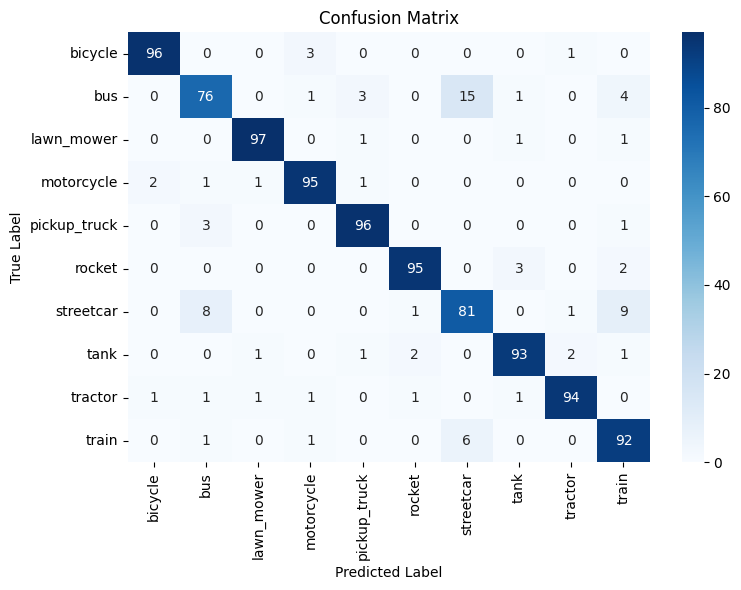

TP: [96 76 97 95 96 95 81 93 94 92]
FP: [ 3 14  3  6  6  4 21  6  4 18]
TN: [897 886 897 894 894 896 879 894 896 882]
FN: [ 4 24  3  5  4  5 19  7  6  8]

Metrics Based on Confusion Matrix:
Accuracy: 0.9150

Class: bicycle
  Precision:  0.9697
  Recall:     0.9600
  Specificity:0.9967
  F1-score:   0.9648

Class: bus
  Precision:  0.8444
  Recall:     0.7600
  Specificity:0.9844
  F1-score:   0.8000

Class: lawn_mower
  Precision:  0.9700
  Recall:     0.9700
  Specificity:0.9967
  F1-score:   0.9700

Class: motorcycle
  Precision:  0.9406
  Recall:     0.9500
  Specificity:0.9933
  F1-score:   0.9453

Class: pickup_truck
  Precision:  0.9412
  Recall:     0.9600
  Specificity:0.9933
  F1-score:   0.9505

Class: rocket
  Precision:  0.9596
  Recall:     0.9500
  Specificity:0.9956
  F1-score:   0.9548

Class: streetcar
  Precision:  0.7941
  Recall:     0.8100
  Specificity:0.9767
  F1-score:   0.8020

Class: tank
  Precision:  0.9394
  Recall:     0.9300
  Specificity:0.9933
  F1-scor

In [ ]:
print(f"Best model will be loaded from '{top_models_dir}'.")
top_model_files = get_models_in_dir(top_models_dir)
print(f"Found {len(top_model_files)} models in '{top_models_dir}'.")
model_scores_sorted = sort_models_by_score(top_model_files, top_models_dir)
best_model = model_scores_sorted[0]

print(f"Best model: {best_model}")
# find path to model
best_model_path = os.path.join(top_models_dir, best_model[0])
best_model = torch.load(best_model_path)
model.load_state_dict(best_model['model_state_dict'])
model = model.to(device)

def plot_performance_metrics(mark_best=None):
# Plot performance metrics and mark best model
    plt.figure(figsize=(12, 4))
    best_model_test_loss = None
    best_model_test_acc = None
    if mark_best is not None:
        # Find best model by highest test accuracy
        best_model_index = mark_best.index(max(mark_best, key=lambda x: x[1]))
        best_model_epoch = mark_best[best_model_index][6]
        best_model_test_loss = mark_best[best_model_index][4]
        best_model_test_acc = mark_best[best_model_index][5]

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[:epochs_run], label='Train Loss')
    plt.plot(test_losses[:epochs_run], label='Test Loss')
    plt.scatter(best_model_epoch, best_model_test_loss, color='red', label='Best Model', zorder=5) if best_model_test_loss is not None else None
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies[:epochs_run], label='Train Accuracy')
    plt.plot(test_accuracies[:epochs_run], label='Test Accuracy')
    plt.scatter(best_model_epoch, best_model_test_acc, color='red', label='Best Model', zorder=5) if best_model_test_acc is not None else None
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    # plt.show()

    print(f"Training Loss: {train_losses[:epochs_run]}")
    print(f"Test Loss: {test_losses[:epochs_run]}")
    print(f"Training Accuracy: {train_accuracies[:epochs_run]}%")
    print(f"Test Accuracy: {test_accuracies[:epochs_run]}%")

def generate_confusion_matrix(model, test_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return confusion_matrix(all_labels, all_preds)

def print_confusion_matrix(cm, class_names):
    print("Confusion Matrix (rows = true labels, columns = predicted labels):")
    print("\t" + "\t".join(class_names))
    for i, row in enumerate(cm):
        print(f"{class_names[i]}\t" + "\t".join(map(str, row)))

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def calculate_metrics(cm):
    epsilon = 1e-10
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fp + fn)
    
    print(f"TP: {tp}")
    print(f"FP: {fp}")
    print(f"TN: {tn}")
    print(f"FN: {fn}")

    accuracy = np.sum(tp) / np.sum(cm)

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)

    return accuracy, precision, recall, specificity, f1

plot_performance_metrics(mark_best=model_scores_sorted)

cm = generate_confusion_matrix(model, test_loader, class_names, device)
print_confusion_matrix(cm, class_names)

accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)

print("\nMetrics Based on Confusion Matrix:")
print(f"Accuracy: {accuracy:.4f}")
for i, name in enumerate(class_names):
    print(f"\nClass: {name}")
    print(f"  Precision:  {precision[i]:.4f}")
    print(f"  Recall:     {recall[i]:.4f}")
    print(f"  Specificity:{specificity[i]:.4f}")
    print(f"  F1-score:   {f1_score[i]:.4f}")
    
macs, params = profile(model, inputs=(torch.randn(1, 3, 224, 224).to(device),))
print(f"FLOPs: {macs / 1e6:.2f} MFLOPs, Params: {params/1e6:.2f} M")

plt.show()

graph = draw_graph(
    model,
    input_size=(1, 3, 224, 224),  # batch size of 1
    expand_nested=False,
    roll=False,
    device="cpu",
    depth=3,
)

graph.visual_graph
